# The optimal filter of Wiener
Joint work with Charlie Peskin (NYU) $\newcommand{\mf}{\mathfrak} \newcommand{\E}{\mathrm{e}} \newcommand{\D}{\mathrm{d}}$ 

In [1]:
using ApproxFunRational, AbstractIterativeSolvers, Plots

Consider the problem of filtering signals from noise:

**Problem**

An input is receiving a signal $\mf s(t)$, noise $\mf n(t)$ and the input has its own internal noise $\mf m(t)$.  Suppose $\mf s,\mf n,\mf m$ are independent mean-zero stationary stochastic processes.  Given a delay $D \geq 0$ find a function $f(t)$ so that the Wiener functional
\begin{align*}
    \mathbb E \left[ \mf s(t -D) - \int_0^\infty f(t') \mf r(t - t') \D t' \right]^2, \quad \mf r(t) = \mf s(t) + \mf n(t) + \mf m(t)
\end{align*}
is minimized.

Define the correlation functions for $t \geq t'$
\begin{align*}
 \Phi_{\mf s\mf s}(t - t') = \mathbb E [\mf s(t)\mf s(t')], ~~ \Phi_{\mf n \mf n}(t - t') = \mathbb E [\mf n(t) \mf n(t')], ~~ \Phi_{\mf m\mf m}(t - t') = \mathbb E [\mf m(t) \mf m(t')].
\end{align*}

A simple realistic assumption is that $\mf s(t)$ takes one of two values $\pm s_0$, between successive points in a Poisson process. The value is chosen independently of the Poisson process and $\mathbb P(\mf s(a) = s_0) = \mathbb P(\mf s(a) = -s_0) = \frac{1}{2}$. A common assumption is that $\mf m(t)$ (and $\mf n$) is not actually a function, but rather, it is white noise.  For these considerations and $a < b$ we have
  \begin{align}\label{eq:exp}\begin{split}
    \mathbb E[\mf s(a) \mf s(b)] & = s_0^2\mathbb P( \mf s(a) = s_0 \And \mf s(b) = s_0)\\
                                 & - s_0^2 \mathbb P( \mf s(a) = -s_0 \And \mf s(b) = s_0)\\
                                 & - s_0^2 \mathbb P( \mf s(a) = s_0 \And \mf s(b) = -s_0)\\
                                 & + s_0^2 \mathbb P( \mf s(a) = -s_0 \And \mf s(b) = -s_0).
  \end{split}\end{align}
  

Then, we compute these probabilities.  Let $N(a,b)$ be the number of points of the Poisson process in the interval $(a,b)$.  Then
  \begin{align*}
    &\mathbb P( \mf s(a) = s_0 \And \mf s(b) = s_0) \\
    & = \mathbb P( \mf s(b) = s_0 | \mf s(a) = s_0 \And N(a,b) = 0)\mathbb P( s(a) = s_0) \mathbb P(N(a,b) = 0)\\
    & + \mathbb P( \mf s(b) = s_0 | \mf s(a) = s_0 \And N(a,b) > 0)\mathbb P( s(a) = s_0) \mathbb P(N(a,b) = 0)\\
    & = 1 \cdot \frac{1}{2} \cdot \E^{-\lambda(b-a)} + \frac{1}{2} \cdot \frac{1}{2} \cdot \left( 1 - \E^{-\lambda(b-a)}\right) = \frac{1}{4} \left( 1 + \E^{-\lambda(b-a)} \right).\\
 %   &\mathbb P( \mf s(a) = -s_0 \And \mf s(b) = s_0) \\
 %   & = \mathbb P( \mf s(b) = s_0 | \mf s(a) = -s_0 \And N(a,b) = 0)\mathbb P( s(a) = -s_0) \mathbb P(N(a,b) = 0)\\
%    & + \mathbb P( \mf s(b) = s_0 | \mf s(a) = -s_0 \And N(a,b) > 0)\mathbb P( s(a) = -s_0) \mathbb P(N(a,b) = 0)\\
%    & = 0 \cdot \frac{1}{2} \cdot \E^{-\lambda(b-a)} + \frac{1}{2} \cdot \frac{1}{2} \cdot \left( 1 - \E^{-\lambda(b-a)}\right)\\
%    &\mathbb E[\mf s(a) \mf s(b)] = s^2_0 \E^{-\lambda(b-a)}. 
  \end{align*}
  Here we have assumed the Poisson process is homogeneous with rate $\lambda > 0$.  A similar computation follows for each combination to give
  \begin{align*}
    \mathbb E[\mf s(a) \mf s(b)] = s^2_0 \E^{-\lambda(b-a)}. 
  \end{align*}
  For white noise, with intensities $p,q$, we have
  \begin{align*}
    \mathbb E[\mf n (a) \mf n (b)] = p \delta(b-a), ~~ \mathbb E[\mf m (a) \mf m (b)] = q \delta(b-a).
  \end{align*}

After taking the Fourier transform of the equation found by setting the first variation of the functional to zero we arrive a scalar Weiner-Hopf (Riemann-Hilbert) problem

$$
M^{+}(\omega) = \left[ \frac{2 \lambda s_0^2}{\lambda^2 + \omega^2} + p + q \right] M^-(\omega) - \frac{2 \lambda s_0^2}{\lambda^2 +\omega^2} \E^{-i \omega D}, \quad M(\infty) = 0.
$$

Note that the inhomogeneity is oscillatory and decays slowly.

Here $\mf n, \mf m$ are taken to be white noise with intensities $p,q$, respectively.  The signal $\mf s$ is taken to be a telegraph process, jumping between values $\pm s_0$ at the points of a homogeneous Poisson process with intensity $\lambda$.

In [2]:
tol = 1e-14#1.e-4
λ = 1.
s₀ = 1.0/sqrt(2)
p = .4
q = 0.
d = 8.0
L = 1.;

Set up `Funs` and operators.

In [3]:
Pss = ω -> 2*λ*s₀^2/(λ^2+ω^2)
G = SumFun(Fun(zai(Pss),OscLaurent(0.0,L)) + Fun(OscLaurent(0.0,L),[p]))
H = SumFun(Fun(zai(Pss),OscLaurent(-d,L)))
𝓒⁻ = Cauchy(-1); 𝓕 = FourierTransform(-1.0)
One = SumFun(Fun(1.,OscLaurent(0.0,L)));

Run GMRES __[TT 2013]__

In [4]:
𝓢 = x -> x - (G-One)*(𝓒⁻*x)
out = GMRES(𝓢,H,⋅,10*tol,30, x -> x);
û = +([out[2][i]*out[1][i] for i=1:length(out[2])]...);

iteration = 2, residual = 0.07706882072957948
iteration = 3, residual = 0.023107441425007227
iteration = 4, residual = 0.006834819412149592
iteration = 5, residual = 0.0020472003393000133
iteration = 6, residual = 0.0006686356821460711
iteration = 7, residual = 0.0002175086948151992
iteration = 8, residual = 6.038488026018908e-5
iteration = 9, residual = 1.932407500158689e-5
iteration = 10, residual = 5.893165316801977e-6
iteration = 11, residual = 1.7222968347609136e-6
iteration = 12, residual = 5.330586642888601e-7
iteration = 13, residual = 1.4032876831768587e-7
iteration = 14, residual = 4.53854729794924e-8
iteration = 15, residual = 1.3128444147300389e-8
iteration = 16, residual = 4.24394705795662e-9
iteration = 17, residual = 1.154890326706779e-9
iteration = 18, residual = 3.6834138174831213e-10
iteration = 19, residual = 1.1215832806448595e-10
iteration = 20, residual = 3.1594014706609327e-11
iteration = 21, residual = 1.0714575333117068e-11
iteration = 22, residual = 2.93927407

To compute the actual filter, we need to invert the Fourier transform

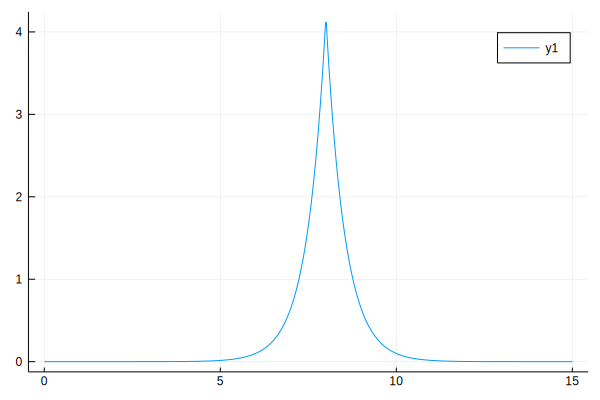

In [5]:
u = 𝓕*û
ω = 0:.01:15
y = map(u,ω)
plot(ω,real(y))